In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [5]:
df = pd.read_csv('Walmart.csv') 
print(f"\nDataset Shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst 5 rows:")
print(df.head())


Dataset Shape: (6435, 8)
Columns: ['Store', 'Date', 'Weekly_Sales', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment']

First 5 rows:
   Store        Date  Weekly_Sales  Holiday_Flag  Temperature  Fuel_Price  \
0      1  05-02-2010    1643690.90             0        42.31       2.572   
1      1  12-02-2010    1641957.44             1        38.51       2.548   
2      1  19-02-2010    1611968.17             0        39.93       2.514   
3      1  26-02-2010    1409727.59             0        46.63       2.561   
4      1  05-03-2010    1554806.68             0        46.50       2.625   

          CPI  Unemployment  
0  211.096358         8.106  
1  211.242170         8.106  
2  211.289143         8.106  
3  211.319643         8.106  
4  211.350143         8.106  


# Data preprocessing

In [6]:
data = df.copy()

# Convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'], format='%d-%m-%Y')

# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())

# Handle missing values (if any)
if data.isnull().sum().sum() > 0:
    # Fill numerical columns with median
    numerical_cols = data.select_dtypes(include=[np.number]).columns
    for col in numerical_cols:
        if data[col].isnull().sum() > 0:
            data[col].fillna(data[col].median(), inplace=True)
    print("Missing values handled")
else:
    print("No missing values found")


Missing Values:
Store           0
Date            0
Weekly_Sales    0
Holiday_Flag    0
Temperature     0
Fuel_Price      0
CPI             0
Unemployment    0
dtype: int64
No missing values found


# Feature Engineering

In [7]:
data['Year'] = data['Date'].dt.year
data['Month'] = data['Date'].dt.month
data['Week'] = data['Date'].dt.isocalendar().week
data['Day'] = data['Date'].dt.day
data['DayOfWeek'] = data['Date'].dt.dayofweek
data['Quarter'] = data['Date'].dt.quarter
data['IsYearEnd'] = (data['Month'] == 12).astype(int)
data['IsYearStart'] = (data['Month'] == 1).astype(int)

# Create lag features (previous week's sales)
data = data.sort_values(['Store', 'Date'])
data['Sales_Lag1'] = data.groupby('Store')['Weekly_Sales'].shift(1)
data['Sales_Lag2'] = data.groupby('Store')['Weekly_Sales'].shift(2)
data['Sales_Lag4'] = data.groupby('Store')['Weekly_Sales'].shift(4)

# Rolling statistics
data['Sales_RollingMean_4'] = data.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).mean()
)
data['Sales_RollingStd_4'] = data.groupby('Store')['Weekly_Sales'].transform(
    lambda x: x.rolling(window=4, min_periods=1).std()
)

print("Time-based features created")
print(f"New features: {['Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter']}")
print(f"Lag features: {['Sales_Lag1', 'Sales_Lag2', 'Sales_Lag4']}")
print(f"Rolling features: {['Sales_RollingMean_4', 'Sales_RollingStd_4']}")

# Remove rows with NaN created by lag features
data = data.dropna()

print(f"\nDataset shape after feature engineering: {data.shape}")

Time-based features created
New features: ['Year', 'Month', 'Week', 'Day', 'DayOfWeek', 'Quarter']
Lag features: ['Sales_Lag1', 'Sales_Lag2', 'Sales_Lag4']
Rolling features: ['Sales_RollingMean_4', 'Sales_RollingStd_4']

Dataset shape after feature engineering: (6255, 21)


# Exploratory Data Analysis (EDA)

In [8]:
print("\nSales Statistics:")
print(data['Weekly_Sales'].describe())


Sales Statistics:
count    6.255000e+03
mean     1.046664e+06
std      5.642170e+05
min      2.099862e+05
25%      5.542012e+05
50%      9.592291e+05
75%      1.419414e+06
max      3.818686e+06
Name: Weekly_Sales, dtype: float64


EDA visualizations saved as 'eda_visualizations.png'


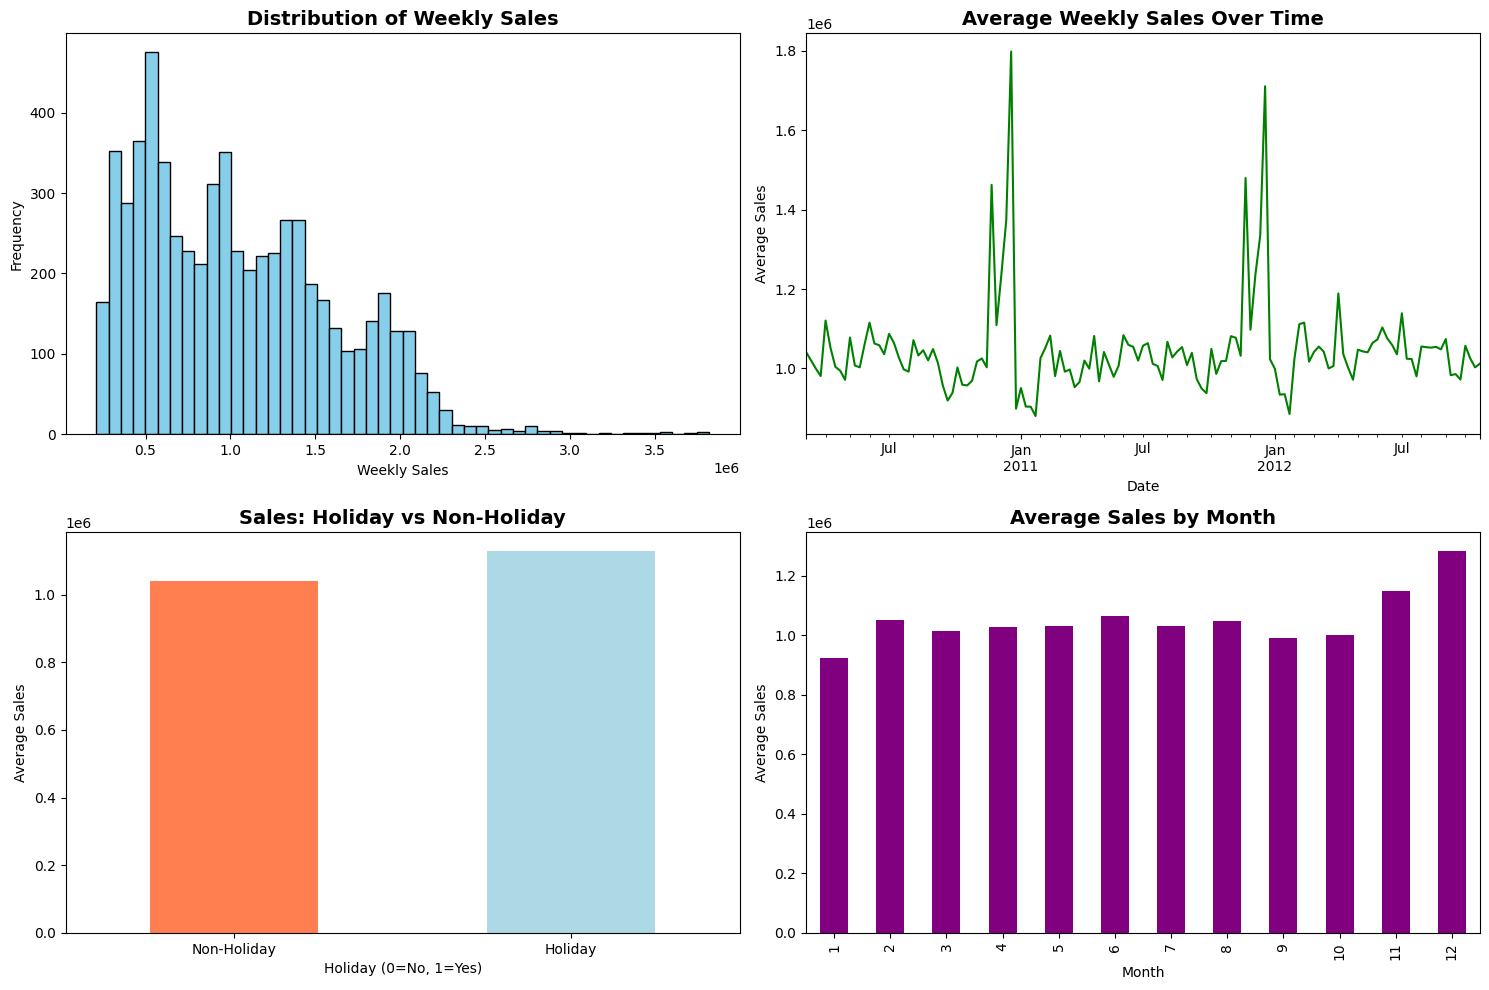

In [10]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Sales distribution
axes[0, 0].hist(data['Weekly_Sales'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Weekly Sales', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Weekly Sales')
axes[0, 0].set_ylabel('Frequency')

# Sales over time
data.groupby('Date')['Weekly_Sales'].mean().plot(ax=axes[0, 1], color='green')
axes[0, 1].set_title('Average Weekly Sales Over Time', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Date')
axes[0, 1].set_ylabel('Average Sales')

# Sales by Holiday
data.groupby('Holiday_Flag')['Weekly_Sales'].mean().plot(kind='bar', ax=axes[1, 0], color=['coral', 'lightblue'])
axes[1, 0].set_title('Sales: Holiday vs Non-Holiday', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Holiday (0=No, 1=Yes)')
axes[1, 0].set_ylabel('Average Sales')
axes[1, 0].set_xticklabels(['Non-Holiday', 'Holiday'], rotation=0)

# Sales by Month
data.groupby('Month')['Weekly_Sales'].mean().plot(kind='bar', ax=axes[1, 1], color='purple')
axes[1, 1].set_title('Average Sales by Month', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Average Sales')

plt.tight_layout()
plt.savefig('eda_visualizations.png', dpi=300, bbox_inches='tight')
print("EDA visualizations saved as 'eda_visualizations.png'")
plt.show()


In [11]:
print("Correlation with Weekly_Sales:")
numerical_features = data.select_dtypes(include=[np.number]).columns
correlations = data[numerical_features].corr()['Weekly_Sales'].sort_values(ascending=False)
print(correlations.head(10))

Correlation with Weekly_Sales:
Weekly_Sales           1.000000
Sales_RollingMean_4    0.975972
Sales_Lag1             0.950875
Sales_Lag2             0.940227
Sales_Lag4             0.936730
Sales_RollingStd_4     0.440067
IsYearEnd              0.116073
Month                  0.080201
Week                   0.078346
Quarter                0.066908
Name: Weekly_Sales, dtype: float64


# Data preparation for modeling

In [12]:
target = 'Weekly_Sales'
exclude_cols = ['Date', 'Weekly_Sales']
feature_cols = [col for col in data.columns if col not in exclude_cols]

X = data[feature_cols]
y = data[target]

print(f"Features selected: {len(feature_cols)}")
print(f"Sample features: {feature_cols[:10]}")

Features selected: 19
Sample features: ['Store', 'Holiday_Flag', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment', 'Year', 'Month', 'Week', 'Day']


In [14]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")

Training set: 5004 samples
Testing set: 1251 samples


In [15]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed")

Feature scaling completed


# Linear Regression Model

In [16]:
lr_model = LinearRegression()
lr_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_lr_train = lr_model.predict(X_train_scaled)
y_pred_lr_test = lr_model.predict(X_test_scaled)

# Evaluate
def evaluate_model(y_true, y_pred, model_name, dataset_type):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    r2 = r2_score(y_true, y_pred)
    
    print(f"{model_name} - {dataset_type} Set:")
    print(f"  RMSE: ${rmse:,.2f}")
    print(f"  MAE:  ${mae:,.2f}")
    print(f"  MAPE: {mape:.2f}%")
    print(f"  R²:   {r2:.4f}")
    
    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2}

lr_train_metrics = evaluate_model(y_train, y_pred_lr_train, "Linear Regression", "Training")
lr_test_metrics = evaluate_model(y_test, y_pred_lr_test, "Linear Regression", "Testing")

Linear Regression - Training Set:
  RMSE: $95,691.95
  MAE:  $57,828.61
  MAPE: 5.79%
  R²:   0.9726
Linear Regression - Testing Set:
  RMSE: $73,969.25
  MAE:  $45,997.83
  MAPE: 6.92%
  R²:   0.9642


In [17]:
lr_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Coefficient': lr_model.coef_
}).sort_values('Coefficient', key=abs, ascending=False)

print("Top 10 Important Features (Linear Regression):")
print(lr_feature_importance.head(10))

Top 10 Important Features (Linear Regression):
                Feature   Coefficient
7                 Month -3.203089e+06
8                  Week  3.179381e+06
17  Sales_RollingMean_4  1.198975e+06
14           Sales_Lag1 -3.301609e+05
15           Sales_Lag2 -3.102780e+05
9                   Day -2.938529e+05
6                  Year -4.769313e+04
18   Sales_RollingStd_4 -4.358914e+04
13          IsYearStart -4.043582e+04
11              Quarter  3.145363e+04


# Random Forest Model

In [18]:
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=20,
    min_samples_split=5,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

print("Training Random Forest...")
rf_model.fit(X_train, y_train)

# Make predictions
y_pred_rf_train = rf_model.predict(X_train)
y_pred_rf_test = rf_model.predict(X_test)

# Evaluate
rf_train_metrics = evaluate_model(y_train, y_pred_rf_train, "Random Forest", "Training")
rf_test_metrics = evaluate_model(y_test, y_pred_rf_test, "Random Forest", "Testing")

Training Random Forest...
Random Forest - Training Set:
  RMSE: $34,569.87
  MAE:  $19,427.26
  MAPE: 1.81%
  R²:   0.9964
Random Forest - Testing Set:
  RMSE: $64,503.26
  MAE:  $30,796.98
  MAPE: 3.81%
  R²:   0.9728


In [19]:
rf_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 Important Features (Random Forest):")
print(rf_feature_importance.head(10))


Top 10 Important Features (Random Forest):
                Feature  Importance
17  Sales_RollingMean_4    0.939856
14           Sales_Lag1    0.018143
18   Sales_RollingStd_4    0.013944
8                  Week    0.009183
16           Sales_Lag4    0.006931
9                   Day    0.004981
15           Sales_Lag2    0.002992
4                   CPI    0.000702
2           Temperature    0.000642
1          Holiday_Flag    0.000577


In [20]:
rf_feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': rf_model.feature_importances_
}).sort_values('Importance', ascending=False)

print("Top 10 Important Features (Random Forest):")
print(rf_feature_importance.head(10))

Top 10 Important Features (Random Forest):
                Feature  Importance
17  Sales_RollingMean_4    0.939856
14           Sales_Lag1    0.018143
18   Sales_RollingStd_4    0.013944
8                  Week    0.009183
16           Sales_Lag4    0.006931
9                   Day    0.004981
15           Sales_Lag2    0.002992
4                   CPI    0.000702
2           Temperature    0.000642
1          Holiday_Flag    0.000577


# Model Comparison

In [21]:
comparison_df = pd.DataFrame({
    'Metric': ['RMSE', 'MAE', 'MAPE (%)', 'R²'],
    'Linear Regression (Train)': [lr_train_metrics['RMSE'], lr_train_metrics['MAE'], 
                                   lr_train_metrics['MAPE'], lr_train_metrics['R2']],
    'Linear Regression (Test)': [lr_test_metrics['RMSE'], lr_test_metrics['MAE'], 
                                  lr_test_metrics['MAPE'], lr_test_metrics['R2']],
    'Random Forest (Train)': [rf_train_metrics['RMSE'], rf_train_metrics['MAE'], 
                              rf_train_metrics['MAPE'], rf_train_metrics['R2']],
    'Random Forest (Test)': [rf_test_metrics['RMSE'], rf_test_metrics['MAE'], 
                             rf_test_metrics['MAPE'], rf_test_metrics['R2']]
})

print("\n" + comparison_df.to_string(index=False))

# Determine best model
if rf_test_metrics['RMSE'] < lr_test_metrics['RMSE']:
    best_model = "Random Forest"
    best_predictions = y_pred_rf_test
else:
    best_model = "Linear Regression"
    best_predictions = y_pred_lr_test

print(f"Best Model: {best_model}")


  Metric  Linear Regression (Train)  Linear Regression (Test)  Random Forest (Train)  Random Forest (Test)
    RMSE               95691.950620              73969.247944           34569.870952          64503.260478
     MAE               57828.609224              45997.825370           19427.260602          30796.978155
MAPE (%)                   5.788394                  6.920897               1.809652              3.806044
      R²                   0.972648                  0.964215               0.996430              0.972788
Best Model: Random Forest


Model comparison plot saved as 'model_comparison.png'


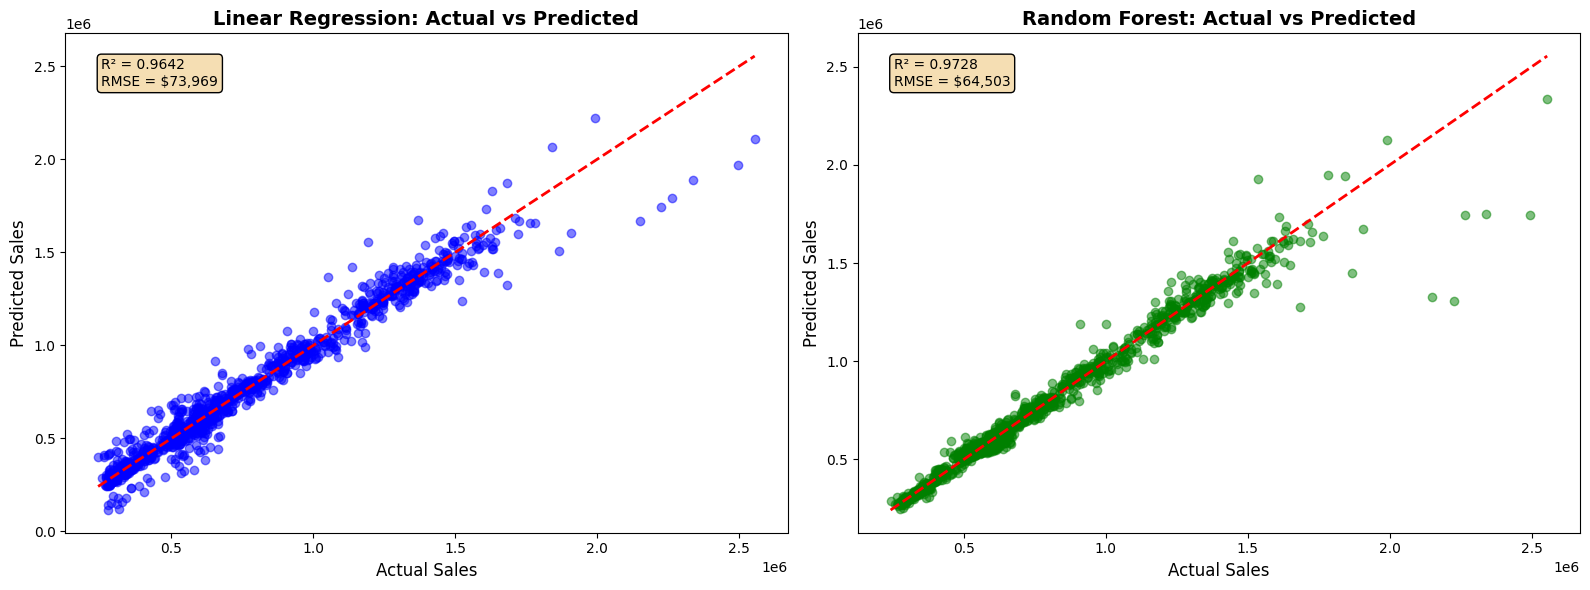

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Linear Regression
axes[0].scatter(y_test, y_pred_lr_test, alpha=0.5, color='blue')
axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Sales', fontsize=12)
axes[0].set_ylabel('Predicted Sales', fontsize=12)
axes[0].set_title('Linear Regression: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[0].text(0.05, 0.95, f'R² = {lr_test_metrics["R2"]:.4f}\nRMSE = ${lr_test_metrics["RMSE"]:,.0f}', 
             transform=axes[0].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

# Random Forest
axes[1].scatter(y_test, y_pred_rf_test, alpha=0.5, color='green')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
axes[1].set_xlabel('Actual Sales', fontsize=12)
axes[1].set_ylabel('Predicted Sales', fontsize=12)
axes[1].set_title('Random Forest: Actual vs Predicted', fontsize=14, fontweight='bold')
axes[1].text(0.05, 0.95, f'R² = {rf_test_metrics["R2"]:.4f}\nRMSE = ${rf_test_metrics["RMSE"]:,.0f}', 
             transform=axes[1].transAxes, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat'))

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300, bbox_inches='tight')
print("Model comparison plot saved as 'model_comparison.png'")
plt.show()

Prediction errors plot saved as 'prediction_errors.png'


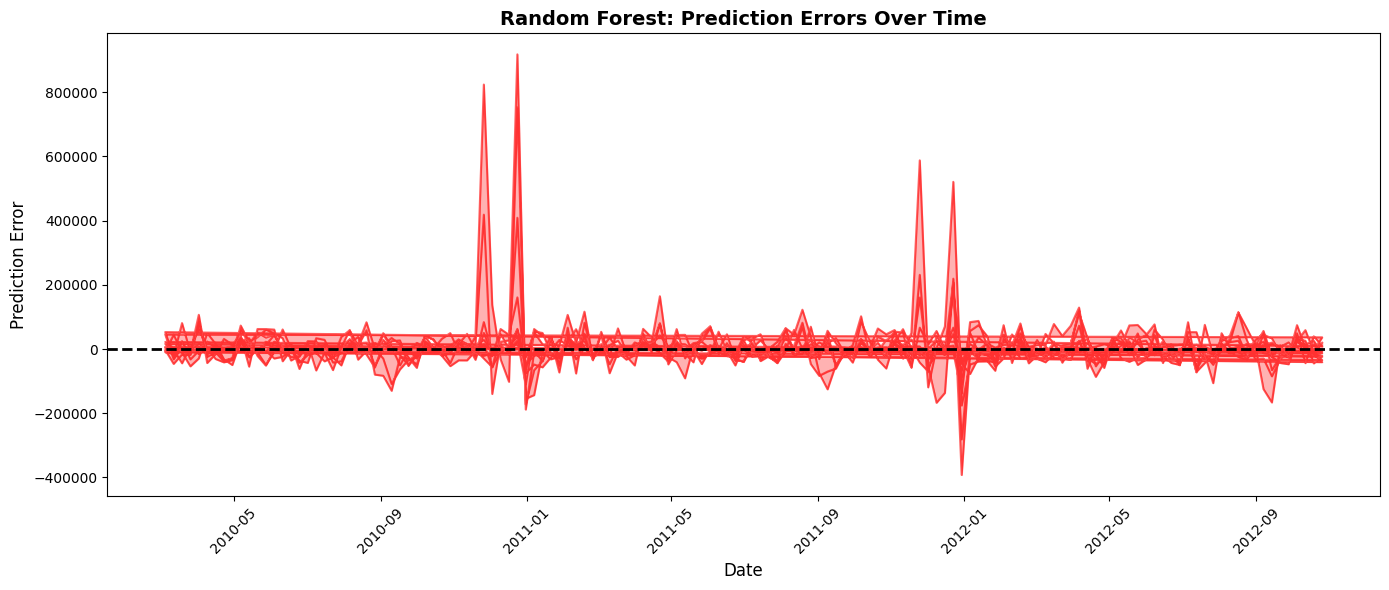

In [24]:
fig, ax = plt.subplots(figsize=(14, 6))

test_dates = data.loc[X_test.index, 'Date']
errors = y_test.values - best_predictions

ax.plot(test_dates, errors, color='red', alpha=0.6)
ax.axhline(y=0, color='black', linestyle='--', linewidth=2)
ax.fill_between(test_dates, errors, 0, alpha=0.3, color='red')

ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Prediction Error', fontsize=12)
ax.set_title(f'{best_model}: Prediction Errors Over Time',
             fontsize=14, fontweight='bold')

plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('prediction_errors.png', dpi=300, bbox_inches='tight')
print("Prediction errors plot saved as 'prediction_errors.png'")
plt.show()

# Save Models

In [25]:
import pickle

with open('linear_regression_model.pkl', 'wb') as f:
    pickle.dump(lr_model, f)
with open('random_forest_model.pkl', 'wb') as f:
    pickle.dump(rf_model, f)
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

print("Models saved successfully!")
print("  - linear_regression_model.pkl")
print("  - random_forest_model.pkl")
print("  - scaler.pkl")

Models saved successfully!
  - linear_regression_model.pkl
  - random_forest_model.pkl
  - scaler.pkl
